<a href="https://colab.research.google.com/github/fmuranda/Remote-Sensing/blob/main/tutorials/W1D2_Ocean-AtmosphereReanalysis/W1D2_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neuromatch/climate-course-content/blob/main/tutorials/W1D2_Ocean-AtmosphereReanalysis/W1D2_Tutorial2.ipynb) &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/climate-course-content/main/tutorials/W1D2_Ocean-AtmosphereReanalysis/W1D2_Tutorial2.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 2: A Lot of Weather Makes Climate - Exploring the ERA5 Reanalysis

**Week 1, Day 2, Ocean-Atmosphere Reanalysis**

**Content creators:** Momme Hell

**Content reviewers:** Katrina Dobson, Danika Gupta, Maria Gonzalez, Will Gregory, Nahid Hasan, Paul Heubel, Sherry Mi, Beatriz Cosenza Muralles, Jenna Pearson, Chi Zhang, Ohad Zivan

**Content editors:** Paul Heubel, Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Paul Heubel, Jenna Pearson, Konstantine Tsafatinos, Chi Zhang, Ohad Zivan

**Our 2024 Sponsors:** NFDI4Earth, CMIP

# Tutorial Objectives

*Estimated timing of tutorial:* 25 mins

In the previous tutorial, we learned about the El Niño Southern Oscillation (ENSO), which is a specific atmosphere-ocean dynamical phenomenon. You will now examine the atmosphere and the ocean systems more generally.

In this tutorial, you will learn to work with reanalysis data. These data combine observations and models of the Earth system and are a critical tool for weather and climate science. You will first access a specific reanalysis dataset: ECMWF's ERA5. You will then select variables and slices of interest from the preprocessed file, investigating how important climate variables change on medium-length timescales (hours to months) within a certain region.

By the end of this tutorial, you will be able to:
- Access reanalysis data of climatically important variables.
- Plot interactive maps to explore changes on various time scales.
- Compute and compare time series of different variables from reanalysis data.

# Setup

In [2]:
# installations ( uncomment and run this cell ONLY when using google colab or kaggle )

!pip install xarray==2024.2 scipy cartopy geoviews cdsapi cftime nc-time-axis
# last supported xaray version, see last comment on this thread: https://github.com/pydata/xarray/issues/8909

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 102.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.3/547.3 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 64.6 MB/s eta 0:00:00
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.3.1
    Uninstalling xarray-2025.3.1:
      Successfully uninstalled xarray-2025.3.1


In [3]:
import cdsapi
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import geoviews as gv
import geoviews.feature as gf
import holoviews

import os
import pooch
import tempfile

from cartopy import crs as ccrs

import warnings
#  Suppress warnings issued by Cartopy when downloading data files
warnings.filterwarnings('ignore')

In [4]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "comptools_4clim",
            "user_key": "l5jpxuee",
        },
    ).render()


feedback_prefix = "W1D2_T2"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.6 MB/s eta 0:00:00


In [5]:
# @title Helper functions

def pooch_load(filelocation=None, filename=None, processor=None):
    shared_location = "/home/jovyan/shared/Data/tutorials/W1D2_Ocean-AtmosphereReanalysis"  # this is different for each day
    user_temp_cache = tempfile.gettempdir()

    if os.path.exists(os.path.join(shared_location, filename)):
        file = os.path.join(shared_location, filename)
    else:
        file = pooch.retrieve(
            filelocation,
            known_hash=None,
            fname=os.path.join(user_temp_cache, filename),
            processor=processor,
        )

    return file

In [6]:
# @title Figure Settings
import ipywidgets as widgets  # interactive display

%config InlineBackend.figure_format = 'retina'
plt.style.use(
    "https://raw.githubusercontent.com/neuromatch/climate-course-content/main/cma.mplstyle"
)

In [7]:
# @title Video 1: ECMWF Reanalysis

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'xn_SGxTm6LA'), ('Bilibili', 'BV1g94y1B7Yw')]
tab_contents = display_videos(video_ids, W=730, H=410)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_ECMWF_Reanalysis_Video")

# Section 1: What is Reanalysis Data?

**Reanalysis** refers to the process of combining historical observations from a variety of sources, such as weather stations, satellite measurements, and ocean buoys, with numerical models to create a comprehensive and consistent record of past weather and climate conditions. Reanalysis data is a useful tool to examine the Earth's climate system over a wide range of time scales, from seasonal through decadal to century-scale changes.

There are multiple Earth system reanalysis products (e.g. MERRA-2, NCEP-NCAR, JRA-55C, [see an extensive list here](https://climatedataguide.ucar.edu/climate-data/atmospheric-reanalysis-overview-comparison-tables)), and no single product fits all needs. For this tutorial, you will be using a product from the European Centre for Medium-Range Weather Forecasts (ECMWF) called **ECMWF Reanalysis v5 (ERA5)**. [This video](https://climate.copernicus.eu/climate-reanalysis) from the ECMWF provides you with a brief introduction to the ERA5 product.

## Section 1.1: Accessing ERA5 Data

You will access the data through our OSF cloud storage to simplify the downloading process. If you are keen to download the data yourself or are simply interested in exploring other variables, please have a look into the [```get_ERA5_reanalysis_data.ipynb```](https://github.com/neuromatch/climate-course-content/blob/main/tutorials/W1D2_Ocean-AtmosphereReanalysis/get_ERA5_reanalysis_data.ipynb) notebook, where we use the Climate Data Store (CDS) API to get a subset of the huge [ECMWF ERA5 Reanalysis](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview) data set.

Let's select a specific year and month to work with, March of 2018:

In [8]:
# load data: 5 variables of ERA5 reanalysis, subregion, hourly, March 2018
fname_ERA5_allvars = "ERA5_5vars_032018_hourly_NE-US.nc"
url_ERA5_allvars = "https://osf.io/7kcwn/download"
ERA5_allvars = xr.open_dataset(pooch_load(url_ERA5_allvars, fname_ERA5_allvars))

SHA256 hash of downloaded file: 8415d3380ab72642775ade13eb0f61818ea079e69dc6bade36f898c2bae5687d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


In [9]:
ERA5_allvars

<xarray.Dataset> Size: 152MB
Dimensions:    (longitude: 101, latitude: 101, time: 744)
Coordinates:
  * longitude  (longitude) float32 404B -90.0 -89.75 -89.5 ... -65.25 -65.0
  * latitude   (latitude) float32 404B 55.2 54.95 54.7 54.45 ... 30.7 30.45 30.2
  * time       (time) datetime64[ns] 6kB 2018-03-01 ... 2018-03-31T23:00:00
Data variables:
    u10        (time, latitude, longitude) float32 30MB ...
    v10        (time, latitude, longitude) float32 30MB ...
    t2m        (time, latitude, longitude) float32 30MB ...
    sst        (time, latitude, longitude) float32 30MB ...
    sp         (time, latitude, longitude) float32 30MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-03-12 10:37:17 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

You just loaded an `xarray` dataset, as introduced on the first day. This dataset contains 5 variables covering the Northeastern United States along with their respective coordinates. With this dataset, you have access to our best estimates of climate parameters with a temporal resolution of 1 hour and a spatial resolution of 1/4 degree (i.e. grid points near the Equator represent a ~25 km x 25 km region). This is a lot of data, but still just a fraction of the data available through the [full ERA5 dataset](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview).


## Section 1.2: Selecting Regions of Interest
The global ERA5 data over the entire time range is so large that even just one variable would be too large to store on your computer. Here we use preprocessed slices of an example region, to load another region (i.e., a spatial subset) of the data, please check out the ```get_ERA5_reanalysis_data.ipynb``` notebook. In this first example, you will load *air surface temperature at 2 meters* data for a small region in the Northeastern United States. In later tutorials, you will have the opportunity to select a region of your choice and explore other climate variables.

The magnitude of the wind vector represents the wind speed

\begin{align}
||u|| = \sqrt{u^2 + v^2}
\end{align}

which you will use later in the tutorial for time series comparison and discuss in more detail in Tutorial 4. We will calculate that here and add it to our dataset.

In [10]:
# compute ten-meter wind speed, the magnitude of the wind vector
ERA5_allvars["wind_speed"] = np.sqrt(
    ERA5_allvars["u10"] ** 2
    + ERA5_allvars["v10"] ** 2
)
# add name and units to the metadata:
ERA5_allvars["wind_speed"].attrs[
    "long_name"
] = "10-meter wind speed"  # assigning the long name to the attributes
ERA5_allvars["wind_speed"].attrs["units"] = "m/s"  # assigning units
ERA5_allvars

<xarray.Dataset> Size: 182MB
Dimensions:     (longitude: 101, latitude: 101, time: 744)
Coordinates:
  * longitude   (longitude) float32 404B -90.0 -89.75 -89.5 ... -65.25 -65.0
  * latitude    (latitude) float32 404B 55.2 54.95 54.7 ... 30.7 30.45 30.2
  * time        (time) datetime64[ns] 6kB 2018-03-01 ... 2018-03-31T23:00:00
Data variables:
    u10         (time, latitude, longitude) float32 30MB -3.345 ... -3.221
    v10         (time, latitude, longitude) float32 30MB 2.463 2.297 ... -2.706
    t2m         (time, latitude, longitude) float32 30MB ...
    sst         (time, latitude, longitude) float32 30MB ...
    sp          (time, latitude, longitude) float32 30MB ...
    wind_speed  (time, latitude, longitude) float32 30MB 4.154 4.124 ... 4.207
Attributes:
    Conventions:  CF-1.6
    history:      2024-03-12 10:37:17 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

# Section 2: Plotting Spatial Maps of Reanalysis Data
First, let's plot the region's surface temperature for the first time step of the reanalysis dataset. To do this let's extract the 2m air temperature data from the dataset that contains all the variables.

In [11]:
ds_surface_temp_2m = ERA5_allvars.t2m
ds_surface_temp_2m

<xarray.DataArray 't2m' (time: 744, latitude: 101, longitude: 101)> Size: 30MB
[7589544 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 404B -90.0 -89.75 -89.5 ... -65.25 -65.0
  * latitude   (latitude) float32 404B 55.2 54.95 54.7 54.45 ... 30.7 30.45 30.2
  * time       (time) datetime64[ns] 6kB 2018-03-01 ... 2018-03-31T23:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature

We will be plotting this a little bit differently than you have previously plotted a map (and differently from how you will plot in most tutorials) so we can look at a few times steps interactively later. To do this we are using the packages [geoviews](https://geoviews.org) and [holoviews](https://holoviews.org/).

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
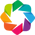

:Overlay
   .Image.I     :Image   [longitude,latitude]   (2 metre temperature)
   .Coastline.I :Feature   [Longitude,Latitude]

In [12]:
holoviews.extension("bokeh")

dataset_plot = gv.Dataset(ds_surface_temp_2m.isel(time=0))  # select the first time step

# create the image
images = dataset_plot.to(
    gv.Image, ["longitude", "latitude"], ["t2m"], "hour"
)

# aesthetics, add coastlines etc.
images.opts(
    cmap="coolwarm",
    colorbar=True,
    width=600,
    height=400,
    projection=ccrs.PlateCarree(),
    clabel="2m Air Temperature (K)",
) * gf.coastline

In the above figure, coastlines are shown as black lines. Most of the selected region is land, with some ocean (lower right) and a lake (top middle).

Next, we will examine variability at two different frequencies using interactive plots:

1. **Hourly variability**
2. **Daily variability**

Note that in the previous tutorial, you computed the monthly variability, or *climatology*, but here you only have one month of data loaded (March 2018). If you are curious about longer timescales you will visit this in the next tutorial!

In [13]:
# average temperatures over the whole month after grouping by the hour
ds_surface_temp_2m_hour = ds_surface_temp_2m.groupby("time.hour").mean()

In [14]:
# interactive plot of hourly frequency of surface temperature
# this cell may take a little longer as it contains several maps in a single plotting function
dataset_plot = gv.Dataset(
    ds_surface_temp_2m_hour.isel(hour=slice(0, 12))
)  # only the first 12 time steps (midnight to noon), as it is a time-consuming task
images = dataset_plot.to(
    gv.Image, ["longitude", "latitude"], ["t2m"], "hour"
)
images.opts(
    cmap="coolwarm",
    colorbar=True,
    width=600,
    height=400,
    projection=ccrs.PlateCarree(),
    clabel="2m Air Temperature (K)",
) * gf.coastline

:HoloMap   [hour]
   :Overlay
      .Image.I     :Image   [longitude,latitude]   (2 metre temperature)
      .Coastline.I :Feature   [Longitude,Latitude]

In [16]:
# average temperatures over the whole day after grouping by the day
ds_surface_temp_2m_day = ds_surface_temp_2m.groupby("time.day").mean()

In [17]:
# interactive plot of daily frequency of surface temperature
# this cell may take a little longer as it contains several maps in a single plotting function holoviews.extension('bokeh')
dataset_plot = gv.Dataset(
    ds_surface_temp_2m_day.isel(day=slice(0, 10))
)  # only the first 10 time steps, as it is a time-consuming task
images = dataset_plot.to(
    gv.Image, ["longitude", "latitude"], ["t2m"], "day"
)
images.opts(
    cmap="coolwarm",
    colorbar=True,
    width=600,
    height=400,
    projection=ccrs.PlateCarree(),
    clabel="2m Air Temperature (K)",
) * gf.coastline

:HoloMap   [day]
   :Overlay
      .Image.I     :Image   [longitude,latitude]   (2 metre temperature)
      .Coastline.I :Feature   [Longitude,Latitude]

### Questions 2

1. What differences do you notice between the hourly and daily interactive plots, and are there any interesting spatial patterns of these temperature changes?

In [18]:
# to_remove explanation

"""
1. On hourly timescales, the largest changes are over land because it responds faster than the ocean to the diurnal cycle of solar radiation. This is because the ocean has a higher heat capacity than the land surface. On daily timescales, the surface atmospheric temperature shows comparable variations across both the ocean and land.
"""

'\n1. On hourly timescales, the largest changes are over land because it responds faster than the ocean to the diurnal cycle of solar radiation. This is because the ocean has a higher heat capacity than the land surface. On daily timescales, the surface atmospheric temperature shows comparable variations across both the ocean and land.\n'

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Questions_2")

# Section 3: Plotting Time Series of Reanalysis Data

## Section 3.1: Surface Air Temperature Time Series

You have demonstrated that there are a lot of changes in surface temperature within a day and between days. It is crucial to understand this *temporal variability* in the data when performing climate analysis.

Rather than plotting interactive spatial maps for different timescales, in this last section, you will create a time series of surface air temperature from the data you have already examined to look at variability on longer than daily timescales. Instead of taking the mean in ***time*** to create *maps*, you will now take the mean in ***space*** to create *time series*.

*Note that the spatially averaged data will now only have a time coordinate, making it a time series (ts).*

In [19]:
# find weights (this is a regular grid so we can use cos(latitude))
weights = np.cos(np.deg2rad(ds_surface_temp_2m.latitude))
weights.name = "weights"
# take the weighted spatial mean since the latitude range of the region of interest is large
ds_surface_temp_2m_ts = ds_surface_temp_2m.weighted(weights).mean(["longitude", "latitude"])
ds_surface_temp_2m_ts

<xarray.DataArray 't2m' (time: 744)> Size: 6kB
array([279.38584037, 279.24494872, 278.75913557, 278.48046783,
       278.38009129, 277.85248166, 277.75605521, 277.64060111,
       277.30056992, 277.34057824, 276.94051054, 276.95283651,
       276.95396445, 277.10698265, 278.01758498, 278.59560628,
       278.95111325, 279.97577252, 280.19391739, 280.35236692,
       280.50917429, 280.31014646, 279.29536309, 279.03205711,
       278.74928489, 278.5672921 , 277.90611681, 277.49095698,
       277.36531438, 276.83370537, 276.65959395, 276.43157765,
       276.01889491, 275.6874052 , 274.97203268, 274.82266909,
       274.67668961, 274.64726329, 275.61112958, 276.29436998,
       276.76211656, 278.04295616, 278.3632242 , 278.55575841,
       278.84248504, 278.82629841, 278.002278  , 277.59481499,
       277.01638969, 276.58528184, 275.99773967, 275.46772221,
       275.23861874, 274.70894807, 274.56572682, 274.3798628 ,
       273.92796313, 273.75654184, 273.44459465, 273.38546693,
       273.36498426, 273.54036196, 274.80485949, 275.93512595,
       276.61173021, 278.06278898, 278.51087829, 278.84869983,
       279.22413009, 279.33814736, 278.44322336, 278.01481257,
       277.43552892, 277.07001644, 276.18134924, 275.55072917,
       275.31704551, 274.66702161, 274.45556188, 274.19121372,
...
       281.32876755, 282.18758729, 282.57106696, 282.85264901,
       283.10921041, 283.21651717, 282.59880021, 282.37425903,
       282.03392642, 281.89689252, 281.30281793, 281.03805095,
       280.90678802, 280.50690869, 280.38599531, 280.25251033,
       279.84205138, 279.70576141, 279.46375932, 279.2879244 ,
       279.5107021 , 279.91131255, 281.18151113, 281.86652331,
       282.19658038, 283.00238936, 283.26500772, 283.41941786,
       283.3755332 , 283.34502123, 282.17158454, 281.88381553,
       281.5493401 , 281.29961901, 280.55541465, 280.20656156,
       280.10606311, 279.57308729, 279.42787196, 279.28295061,
       278.84296318, 278.61068256, 278.10799693, 278.04097384,
       277.94056247, 278.08583896, 278.97806475, 279.44345654,
       279.75378469, 280.45928258, 280.65594427, 280.76497841,
       280.89947546, 280.85285855, 279.99187364, 279.6525811 ,
       279.11498601, 278.74111184, 277.62346146, 276.84186316,
       276.63021586, 275.65330702, 275.29017679, 275.02505433,
       274.21457949, 273.98886971, 273.75952519, 273.6511265 ,
       273.7389951 , 274.44004463, 276.572807  , 277.74295394,
       278.26333353, 279.38473316, 279.69297988, 279.92764595,
       280.28666107, 280.41365377, 279.54547301, 279.22533168])
Coordinates:
  * time     (time) datetime64[ns] 6kB 2018-03-01 ... 2018-03-31T23:00:00

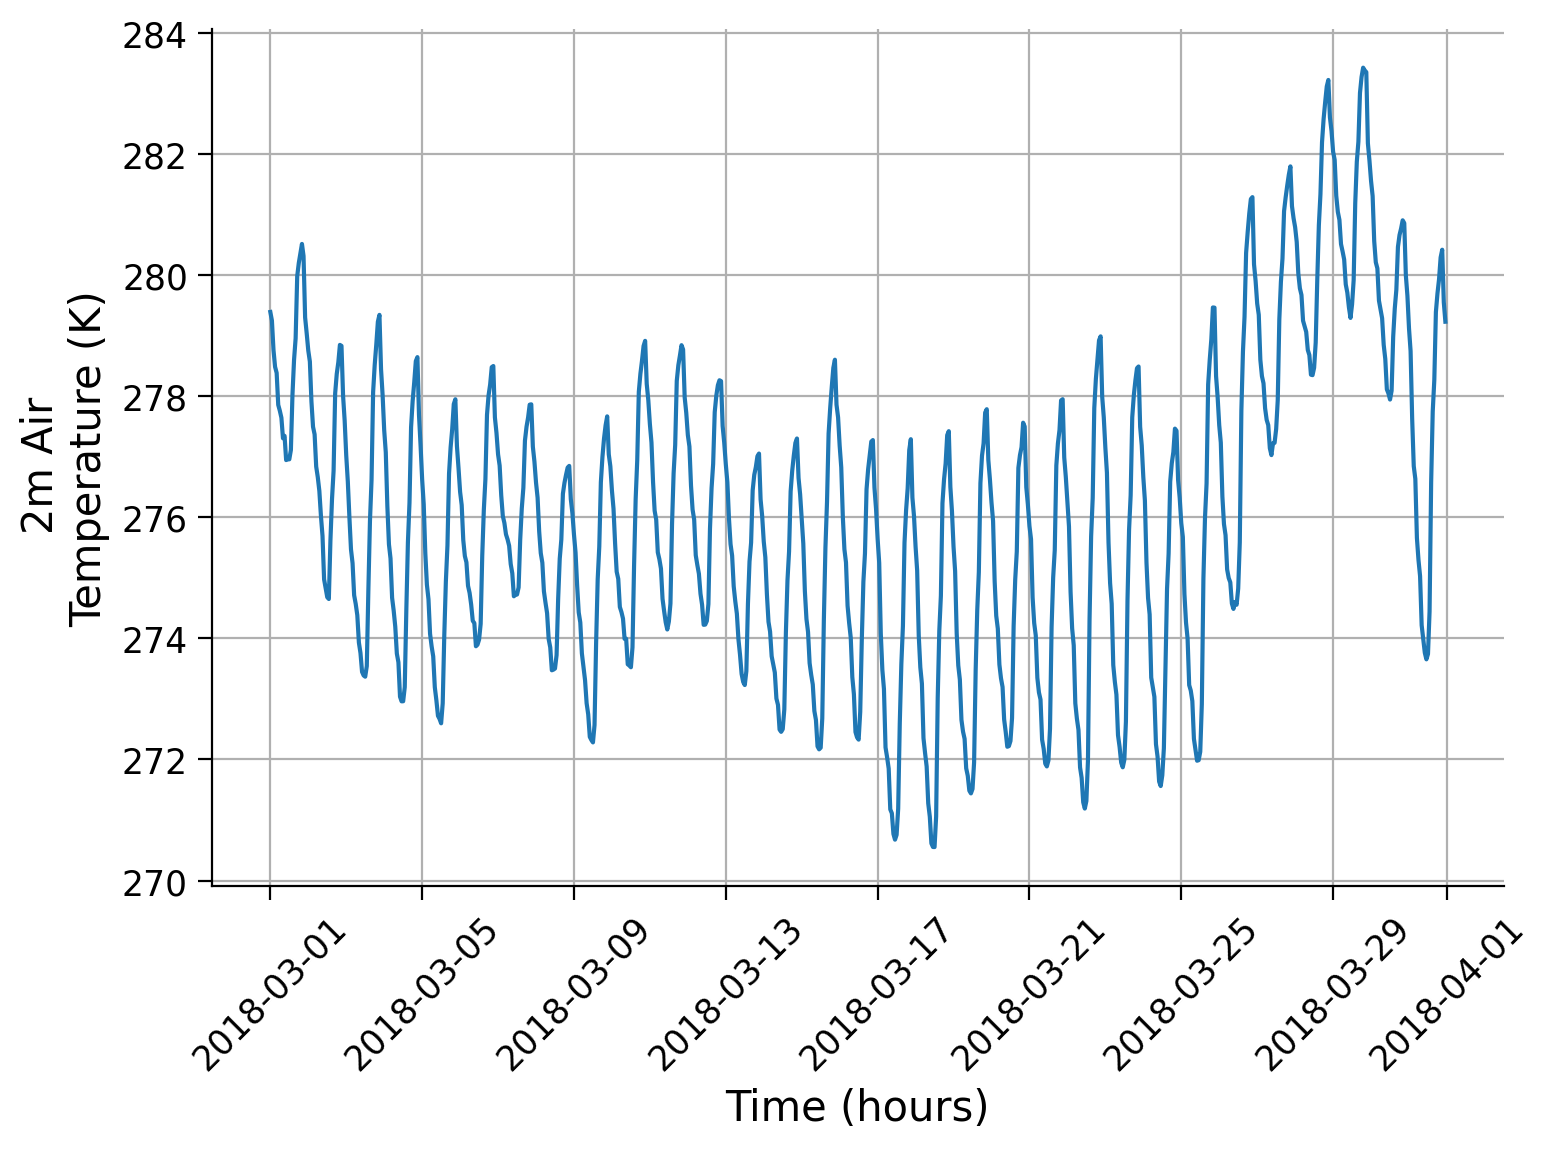

In [20]:
# plot the time series of surface temperature
fig, ax = plt.subplots()

ax.plot(ds_surface_temp_2m_ts.time, ds_surface_temp_2m_ts)

# aesthetics
ax.set_xlabel("Time (hours)")
ax.set_ylabel("2m Air \nTemperature (K)")
ax.xaxis.set_tick_params(rotation=45)
ax.grid(True)

### Questions 3.1
1. What is the dominant source of the high frequency (short timescale) variability?
2. What drives the lower frequency variability?
3. Would the ENSO variablity that you computed in the previous tutorial show up here? Why or why not?

In [21]:
# to_remove explanation
"""
1. The high-frequency variability can largely be attributed to the diurnal cycle or the differences in solar radiation between night and day. This causes large variations in surface temperature, particularly over land and shallow water.
2. The low-frequency variability can be attributed to synoptic patterns (e.g., weather) which can move cold or warm air around on timescales of days to weeks.
3. We do not have a long enough time series for ENSO to show up, but ENSO could indirectly affect this time series by changing weather patterns on shorter timescales.
"""

'\n1. The high-frequency variability can largely be attributed to the diurnal cycle or the differences in solar radiation between night and day. This causes large variations in surface temperature, particularly over land and shallow water.\n2. The low-frequency variability can be attributed to synoptic patterns (e.g., weather) which can move cold or warm air around on timescales of days to weeks.\n3. We do not have a long enough time series for ENSO to show up, but ENSO could indirectly affect this time series by changing weather patterns on shorter timescales.\n'

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Questions_3_1")

## Section 3.2: Comparing Time Series of Multiple Variables

Below you will calculate the time series of the surface air temperature which we just plotted, alongside the time series of several other ERA5 variables for the same period and region: 10-meter wind speed (```wind_speed```), atmospheric surface pressure (```sp```), and sea surface temperature (```sst```).

In [22]:
ERA5_allvars_ts = ERA5_allvars.weighted(weights).mean(["longitude", "latitude"])
ERA5_allvars_ts

<xarray.Dataset> Size: 42kB
Dimensions:     (time: 744)
Coordinates:
  * time        (time) datetime64[ns] 6kB 2018-03-01 ... 2018-03-31T23:00:00
Data variables:
    u10         (time) float64 6kB -0.1129 -0.1174 -0.07807 ... 0.7965 0.4342
    v10         (time) float64 6kB 1.171 1.286 1.376 ... 0.3178 0.1441 0.1829
    t2m         (time) float64 6kB 279.4 279.2 278.8 278.5 ... 280.4 279.5 279.2
    sst         (time) float64 6kB 287.1 287.1 287.1 287.1 ... 286.2 286.4 286.4
    sp          (time) float64 6kB 9.928e+04 9.929e+04 ... 9.938e+04 9.936e+04
    wind_speed  (time) float64 6kB 3.937 4.035 4.114 4.185 ... 5.22 4.726 4.567

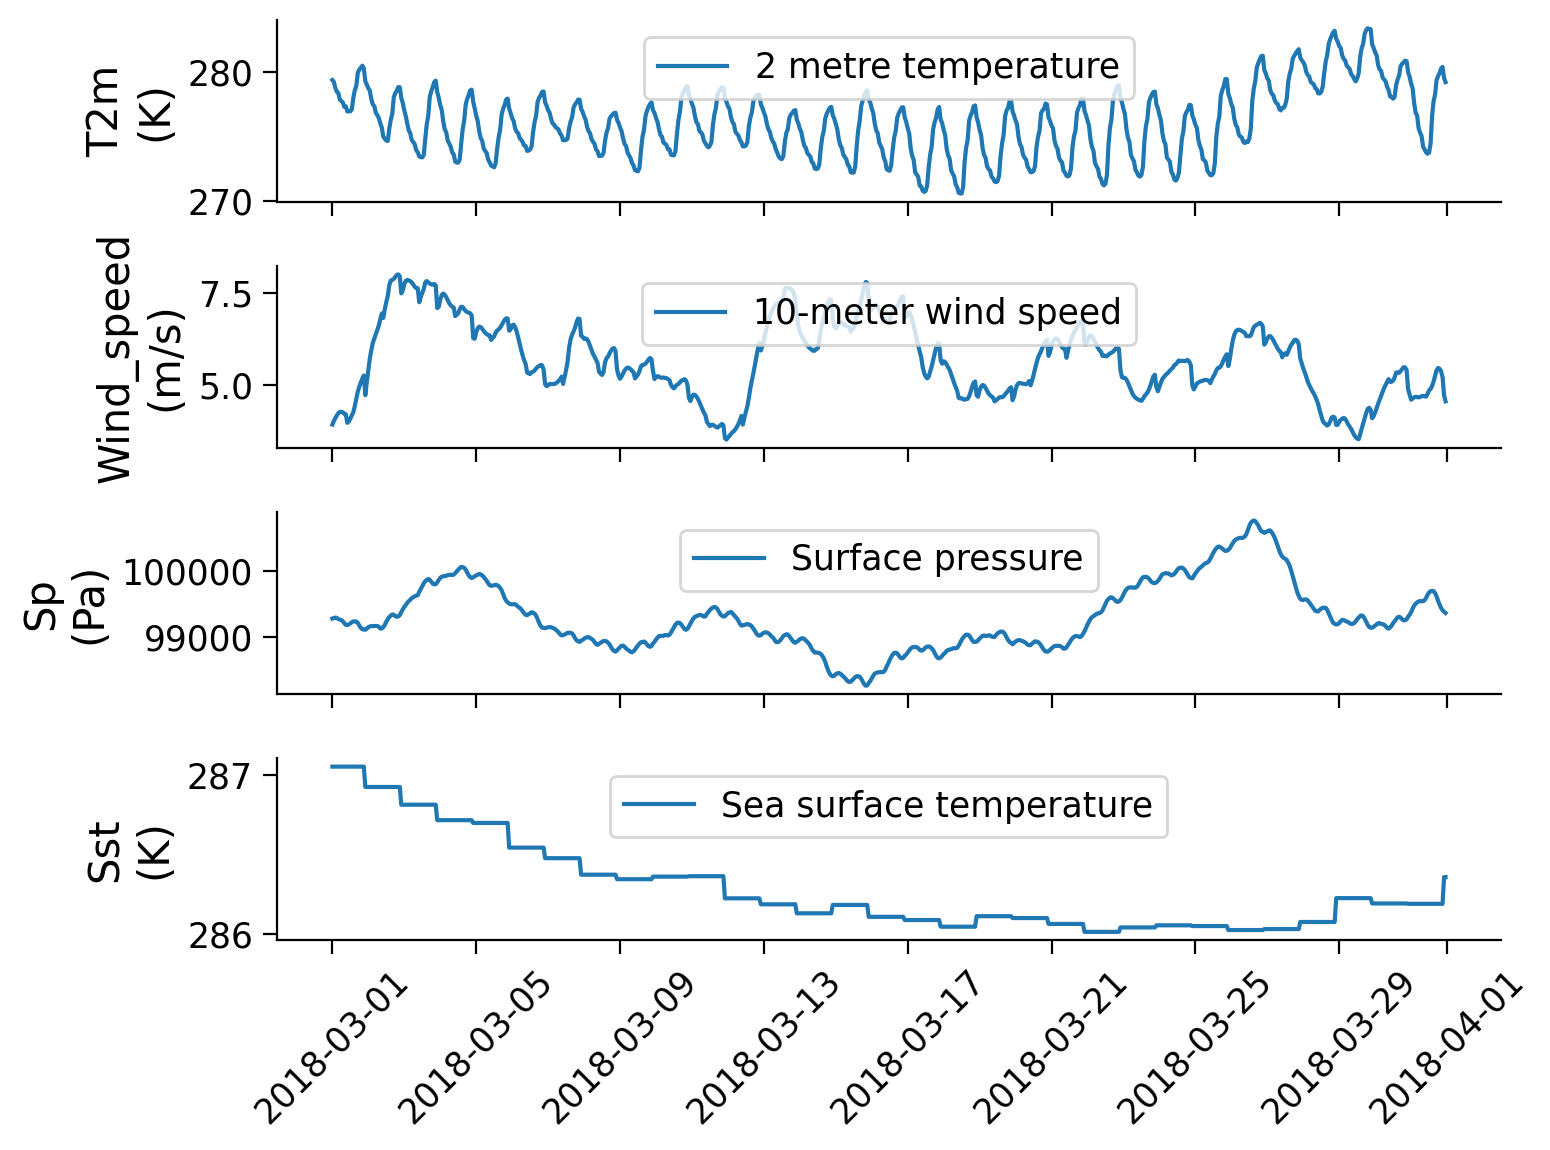

In [23]:
plot_vars = [
    "t2m",        # air temperature at 2 meters
    "wind_speed", # magnitude of the wind vector, cf. Section 1
    "sp",         # surface air pressure
    "sst",        # sea surface temperature
]

fig, ax_list = plt.subplots(len(plot_vars), 1, sharex=True)

for var, ax in zip(plot_vars, ax_list):                   # loop through variables and figure axes
    legend_entry = ERA5_allvars[var].attrs["long_name"]                     # create legend entry
    ax.plot(ERA5_allvars_ts.time, ERA5_allvars_ts[var], label=legend_entry) # plot time series

    # aesthetics
    ax.set_ylabel(f'{var.capitalize()}\n({ERA5_allvars[var].attrs["units"]})') # add ylabel w/ units
    ax.xaxis.set_tick_params(rotation=45)                                      # rotate dates of xticks
    ax.legend(loc='upper center')                       # add legend with shared location (upper center)

### Questions 3.2

Which variable shows variability that is dominated by:
1. The diurnal cycle?
2. The synoptic [~5 day] scale?
3. A mix of these two timescales?
4. Longer timescales?

In [ ]:
# to_remove explanation
"""
1. The 2-meter air temperature is dominated by the diurnal cycle.
2. The surface pressure, which is usually associated with storms, is dominated by the synoptic scale.
3. The 10-meter wind speed shows influences from both the diurnal cycle and the synoptic scale.
4. The ocean surface temperature shows some sensitivity to the diurnal cycle but is dominated by longer timescale (>weeks) variations than the atmospheric variables.
"""

In [24]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Questions_3_2")

# Summary

In this tutorial, you learned how to access and process ERA5 reanalysis data. You are now able to select specific slices within the reanalysis dataset and perform operations such as taking spatial and temporal averages to plot them interactively.

You also looked at different climate variables to distinguish and identify the variability present at different timescales.

# Resources

Data for this tutorial can be accessed [here](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview). We summarized the download procedure in a separate notebook named [```get_ERA5_reanalysis_data.ipynb```](https://github.com/neuromatch/climate-course-content/blob/main/tutorials/W1D2_Ocean-AtmosphereReanalysis/get_ERA5_reanalysis_data.ipynb).